In [1]:
#Import packages
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import distance
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from shapely import wkt
import csv
from pathlib import Path
from shapely.geometry import Point, Polygon, LinearRing
from Assignment_2_Functions import *

## read stations.csv data from OCF, and read grid_points_alameda.csv produced in find_grid_points.ipynb

In [2]:
stations = pd.read_csv('stations.csv')
stations.head()

,Unnamed: 0,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,50462,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
1,50463,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
2,50464,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN
3,50465,US1CAAL0004,37.6483,-121.8745,107.0,CA,PLEASANTON 1.8 SSE,NaN,NaN,NaN
4,50466,US1CAAL0006,37.8319,-122.2503,58.2,CA,OAKLAND 4.4 NNW,NaN,NaN,NaN


In [3]:
geolocator = Nominatim(user_agent='stat159-group_assignment2')

In [4]:
locations_alameda = pd.read_csv("grid_points_alameda.csv")
locations_alameda.head()

,Unnamed: 0,name,lat,lon
0,0,"399, Vassar Avenue, Cragmont, Berkeley, Alamed...",37.904360,-122.272787
1,1,"6599, Gwin Road, Oakland, Alameda County, Cali...",37.847646,-122.216073
2,2,"Denton Place, Oakland, Alameda County, Califor...",37.790932,-122.159359
3,3,"Towhee Trail, Ashland, Alameda County, Califor...",37.734218,-122.102645
4,4,"24499, Sarita Street, Fairview, Alameda County...",37.677504,-122.045931


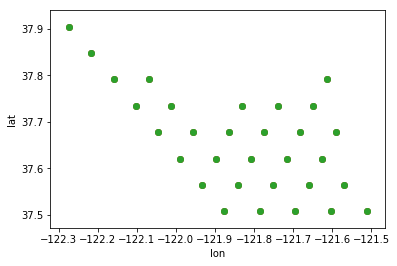

In [20]:
#scatter plot of grid points overlaying Alameda to get the shape of Alameda
plt.scatter(locations_alameda.lon, locations_alameda.lat)
plt.xlabel('lon')
plt.ylabel('lat')
plt.show();

### Write code to identify all weather stations within $x$ miles of Alameda County:

#### Here we use two methods:
#### 1. Method of polygon (we did 5 miles instead of 10 miles for polygon):

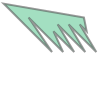

In [6]:
polygon = Polygon(zip(locations_alameda.lon,locations_alameda.lat))
polygon

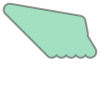

In [7]:
# buffering the original polygon by 5 miles (adjusted from the The Shapely User Manual)
coords = [(x,y)for x,y in zip(locations_alameda.lon,locations_alameda.lat)]
r = LinearRing(coords)
s = Polygon(r)
t = Polygon(s.buffer(0.056713928273561295), [r])
t

In [8]:
within = []
for x,y in zip(stations.LONGITUDE,stations.LATITUDE):
    point = Point(x,y)
    within.append(point.within(t))

In [9]:
stations_within_5miles = stations[within]
stations_within_5miles.head()

,Unnamed: 0,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,50462,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
1,50463,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
2,50464,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN
3,50465,US1CAAL0004,37.6483,-121.8745,107.0,CA,PLEASANTON 1.8 SSE,NaN,NaN,NaN
4,50466,US1CAAL0006,37.8319,-122.2503,58.2,CA,OAKLAND 4.4 NNW,NaN,NaN,NaN


#### 2. Method of grid points: 
Please see function 'within_alameda' in .py file

### Identify all weather stations within 10 miles (not Ranson's 50 miles) of Alameda county:

In [10]:
stations_lat = stations['LATITUDE']
stations_lon = stations['LONGITUDE']

In [11]:
#Get index of weather stations within 10 miles of Alameda using function 'within_alameda'
mask = [within_alameda(10, lat, lon, locations_alameda) for lat, lon in zip(stations_lat, stations_lon)]

#Extract weather stations within 10 miles of Alameda
stations_within_10miles_alameda = stations.loc[mask]
stations_within_10miles_alameda.head()

,Unnamed: 0,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,50462,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
1,50463,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
2,50464,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN
3,50465,US1CAAL0004,37.6483,-121.8745,107.0,CA,PLEASANTON 1.8 SSE,NaN,NaN,NaN
4,50466,US1CAAL0006,37.8319,-122.2503,58.2,CA,OAKLAND 4.4 NNW,NaN,NaN,NaN


In [12]:
#number of weather stations within 10 miles of Alameda
len(stations_within_10miles_alameda)

88

In [13]:
#save to .csv for later use
stations_within_10miles_alameda.iloc[:,1:].to_csv("stations_within_10miles_alameda.csv")

### Find the weighted average inverse distance from each station to the points in the county grid:

In [14]:
#get a list of tuples that contains the latitude and longtitude of the weather stations
loc_stations = list(zip(stations_within_10miles_alameda['LATITUDE'], stations_within_10miles_alameda['LONGITUDE']))

#get a list of tuples that contains the latitude and longtitude of all the grid points in Alameda.
loc_alameda = list(zip(locations_alameda.lat, locations_alameda.lon))

In [15]:
#get the weighted average inverse distance for each station by function 'idwa'
weg_avg_inv_dist = idwa(loc_stations, loc_alameda)

In [16]:
weg_avg_inv_dist[:10]

[0.06789401406379811,
 0.09583860468168928,
 0.0975522997706836,
 0.12340823956560336,
 0.06287881336386607,
 0.08051461618878267,
 0.0835226593030135,
 0.07125996836250492,
 0.13101904586567004,
 0.0649451405965993]

In [17]:
# save the inverse distance for future assignment
stations_within_10miles_alameda['INVDIST'] = weg_avg_inv_dist

/Users/glance/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
stations_within_10miles_alameda.to_csv("stations_within_10miles_alameda.csv")